In [1]:
%matplotlib inline

# Plotting setup
import matplotlib.pyplot as plt
import geopandas

# Package imports
import numpy as np
import pandas as pd

from scipy import stats

# Imports for regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

# Allow import of own scripts #
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
###############################

# Own functions
from src.load_taxi_data import load_taxi_data
from src.taxi_zones_loader import taxi_zones_loader
from src.preprocess_data import preprocess_data
from src.keep_correct_year import keep_correct_year
from src.remove_routes import remove_routes
from src.temporal_preprocessing import temporal_preprocessing
from src.plot_regression_results import plot_regression_results
from src.sklearn_regression import sklearn_regression
from src.sklearn_regression_bf import sklearn_regression_bf
from src.ridge_regression_bf import ridge_regression_bf
from src.keep_correct_month import keep_correct_month

In [2]:
from tueplots import bundles

In [31]:
#plt.rcParams.update(bundles.neurips2021(usetex=False, family="serif"))
#plt.rcParams.update(bundles.icml2022())

**Read raw data:**

In [2]:
# Read previously saved dataframe from csv file from disk
df_taxi_2019_01 = pd.read_csv('../dat/df_taxi_2019_01.csv')

In [2]:
# Download data from TLC
# df_taxi_2019_01 = load_taxi_data(['yellow', 'green', 'fhv'], [2019], [1])

Will download... yellow_tripdata_2019-01.csv
Will download... green_tripdata_2019-01.csv
Will download... fhv_tripdata_2019-01.csv


In [4]:
# Save to disk
# df_taxi_2019_01.to_csv('../dat/df_taxi_2019_01.csv', encoding='utf-8')

In [3]:
df_taxi_2019_01

,Unnamed: 0,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,fleet
0,0,2019-01-01 00:46:40,2019-01-01 00:53:20,151.0,239.0,yellow
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,239.0,246.0,yellow
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,236.0,236.0,yellow
3,3,2018-11-28 15:52:25,2018-11-28 15:55:45,193.0,193.0,yellow
4,4,2018-11-28 15:56:57,2018-11-28 15:58:33,193.0,193.0,yellow
...,...,...,...,...,...,...
31429515,23130805,2019-01-31 23:21:00,2019-01-31 23:28:52,NaN,265.0,fhv
31429516,23130806,2019-01-31 23:38:04,2019-01-31 23:45:43,NaN,265.0,fhv
31429517,23130807,2019-01-31 23:53:58,2019-02-01 00:25:04,NaN,265.0,fhv
31429518,23130808,2019-01-31 23:54:53,2019-02-01 00:00:14,NaN,265.0,fhv


_Number of entries in the raw data set: 31429520_

**Preprocessing**

In [4]:
# Remove invalid data
df_taxi_2019_01 = preprocess_data(df_taxi_2019_01)

# Remove rows with the wrong year
df_taxi_2019_01 = keep_correct_year(df_taxi_2019_01, 2019)

# Remove rows with wrong month
df_taxi_2019_01 = keep_correct_month(df_taxi_2019_01, '01')

# Remove routes that come from or go to locations outside the city
df_taxi_2019_01 = remove_routes(df_taxi_2019_01)

About 5.8060% of the entire data could not be used due to missing information (NaN).
About 0.0013% of the entire data could not be used because they contained the wrong year.
About 0.0442% of the entire data could not be used because they contained the wrong month.
About 5.5675% of the entire data could not be used because "PULocationID" or "DOLocationID" are outside the city.


In [149]:
#df_taxi_2019_01

In [10]:
print('Number of entries in the raw data set: {} rows'.format(df_taxi_2019_01.shape[0]))

Number of entries in the raw data set: 27933517 rows


**Extract temporal features:**

In [5]:
df_taxi_2019_01 = temporal_preprocessing(df_taxi_2019_01)

In [6]:
df_taxi_2019_01

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,fleet,trip_duration,trip_duration_minutes,pickup_month,pickup_day_of_month,pickup_weekday,pickup_hour,pickup_minute
0,2019-01-01 00:46:40,2019-01-01 00:53:20,151,239,yellow,0 days 00:06:40,6.666667,1,1,1,0,46
1,2019-01-01 00:59:47,2019-01-01 01:18:59,239,246,yellow,0 days 00:19:12,19.200000,1,1,1,0,59
7,2019-01-01 00:21:28,2019-01-01 00:28:37,163,229,yellow,0 days 00:07:09,7.150000,1,1,1,0,21
8,2019-01-01 00:32:01,2019-01-01 00:45:39,229,7,yellow,0 days 00:13:38,13.633333,1,1,1,0,32
9,2019-01-01 00:57:32,2019-01-01 01:09:32,141,234,yellow,0 days 00:12:00,12.000000,1,1,1,0,57
...,...,...,...,...,...,...,...,...,...,...,...,...
31429422,2019-01-31 23:09:12,2019-01-31 23:21:25,69,169,fhv,0 days 00:12:13,12.216667,1,31,3,23,9
31429423,2019-01-31 23:14:37,2019-01-31 23:21:25,243,244,fhv,0 days 00:06:48,6.800000,1,31,3,23,14
31429424,2019-01-31 23:20:41,2019-01-31 23:53:05,61,10,fhv,0 days 00:32:24,32.400000,1,31,3,23,20
31429425,2019-01-31 23:33:45,2019-01-31 23:45:16,163,75,fhv,0 days 00:11:31,11.516667,1,31,3,23,33


---

**Drop columns of wrong datatype which cannot be used in the calculation of the correlation matrix:**

In [7]:
# 'pickup_month' is dropped because we only have data of January 2019.
excluded_clms = ['pickup_datetime', 'dropoff_datetime', 'fleet', 'trip_duration', 'pickup_month']

df_taxi_2019_01 = df_taxi_2019_01.drop(columns=excluded_clms, inplace=False)

In [8]:
df_taxi_2019_01

,PULocationID,DOLocationID,trip_duration_minutes,pickup_day_of_month,pickup_weekday,pickup_hour,pickup_minute
0,151,239,6.666667,1,1,0,46
1,239,246,19.200000,1,1,0,59
7,163,229,7.150000,1,1,0,21
8,229,7,13.633333,1,1,0,32
9,141,234,12.000000,1,1,0,57
...,...,...,...,...,...,...,...
31429422,69,169,12.216667,31,3,23,9
31429423,243,244,6.800000,31,3,23,14
31429424,61,10,32.400000,31,3,23,20
31429425,163,75,11.516667,31,3,23,33


# Restrict to single route: JFK Airport (Queens) &rarr; LaGuardia Airport (Queens)

**Analyse _unfiltered_ features:**

Restrict route:

In [9]:
pickup_id  = 132   # JFK Airport (Queens)
dropoff_id = 138   # LaGuardia Airport (Queens)

In [10]:
# Set route fixed but leave all other columns the way they are
df_taxi_2019_01_unfiltered = df_taxi_2019_01[(df_taxi_2019_01['PULocationID'] == pickup_id) &
                                             (df_taxi_2019_01['DOLocationID'] == dropoff_id)]

In [11]:
df_taxi_2019_01_unfiltered = df_taxi_2019_01_unfiltered.drop(columns=['PULocationID', 'DOLocationID'], inplace=False)

In [68]:
# ATTENTION:
#    Seaborn (SNS) uses its own formatting which messes up the TuePlot settings!
#import seaborn as sns

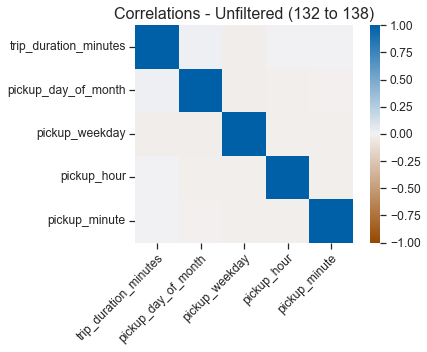

In [20]:
corr       = df_taxi_2019_01_unfiltered.corr()
corr.index = df_taxi_2019_01_unfiltered.columns

# Color blindness safe plot
sns.set(font_scale=1.1)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 250, s=100, l=40, as_cmap=True),
    square=True,
    annot=False
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.tick_params(left=True, bottom=True)

plt.title("Correlations - Unfiltered \n ({} to {})".format(pickup_id, dropoff_id), fontsize=16, pad=20)
plt.savefig('../doc/fig/correlations_before.pdf', bbox_inches='tight')
plt.show()

**Filter Features:**

i.e., remove rows in which there are features with nonsensical values.

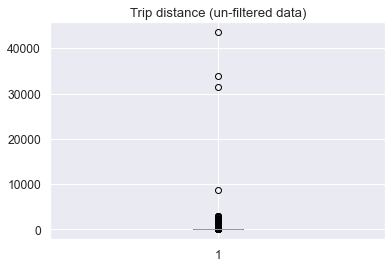

In [22]:
plt.boxplot(df_taxi_2019_01['trip_duration_minutes'])
plt.title('Trip distance (un-filtered data)')
plt.show()

In [12]:
t_lower = 8        # Minimum: 8 minutes.
t_upper = 60       # Maximum: 1 hour => Average longest trip duration according to Google maps is 40 minutes.

#dist_upper = 55    # Maximum sensible distance => Analyses using Google maps showed that the furthest distances within
                   # the NYC taxi are cannot be further than 55 miles.
#dist_lower = 0.3   # Trips must be longer than 0.3 miles (~500 metres)
#amount_lower = 1   # Total fares cannot be less than 1$
#min_passengers = 1 # At least 1 passenger has to be in the taxi
#max_passengers = 5 # It is not possible to have more than 5 passengers in a car

In [13]:
# Filter routes
df_one_route_filtered = df_taxi_2019_01[(df_taxi_2019_01['PULocationID'] == pickup_id)         & \
                                        (df_taxi_2019_01['DOLocationID'] == dropoff_id)        & \
                                        (df_taxi_2019_01['trip_duration_minutes'] < t_upper)   & \
                                        (df_taxi_2019_01['trip_duration_minutes'] > t_lower)]

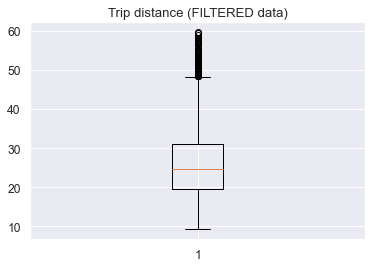

In [43]:
plt.boxplot(df_one_route_filtered['trip_duration_minutes'])
plt.title('Trip distance (FILTERED data)')
plt.show()

Drop columns as they are not needed anymore - The route stays fixed!

In [14]:
df_one_route_filtered = df_one_route_filtered.drop(columns=['PULocationID', 'DOLocationID'], inplace=False)

In [15]:
df_one_route_filtered

,trip_duration_minutes,pickup_day_of_month,pickup_weekday,pickup_hour,pickup_minute
15470,18.483333,1,1,1,27
52808,23.133333,1,1,4,42
59567,17.500000,1,1,4,51
60948,16.133333,1,1,5,29
62018,17.933333,1,1,5,58
...,...,...,...,...,...
31238153,23.950000,31,3,19,59
31239147,34.666667,31,3,19,7
31251301,21.866667,31,3,20,47
31258197,52.350000,31,3,20,31


<p>&nbsp</p>

_How much data is actually left after all processing and after reducing it to one route?_

In [46]:
n_rows_trip_unfiltered = df_taxi_2019_01[(df_taxi_2019_01['PULocationID'] == pickup_id) & \
                                         (df_taxi_2019_01['DOLocationID'] == dropoff_id)].shape[0]
print('After pre-processing but still BEFORE filtering, there are {} rows for our \
selected route.'.format(n_rows_trip_unfiltered))

After pre-processing but still BEFORE filtering, there are 5957 rows for our selected route.


In [47]:
print('AFTER all pre-processing and filtering, there are {} rows left for our \
selected route.'.format(df_one_route_filtered.shape[0]))

AFTER all pre-processing and filtering, there are 5912 rows left for our selected route.


<p>&nbsp</p>

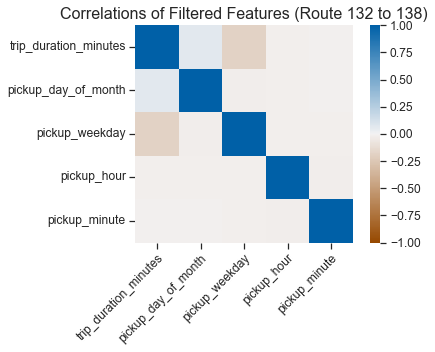

In [100]:
corr       = df_one_route_filtered.corr()
corr.index = df_one_route_filtered.columns

# Color blindness safe plot
sns.set(font_scale=1.1)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 250, s=100, l=40, as_cmap=True),
    square=True,
    annot=False
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.tick_params(left=True, bottom=True)

plt.title("Correlations of Filtered Features \n (Route {} to {})".format(pickup_id, dropoff_id), fontsize=16, pad=20)
plt.savefig('../doc/fig/correlations_after.pdf', bbox_inches='tight')
plt.show()

After filtering the data, i.e., when the features are restricted to more sensible values, different correlations emerge. This is confirmed by plotting, for example, trip distance against trip duration.

However, our initial features of interest (i.e., temporal features like pickup_hour), which we intended to use for predictions are not correlated with the target value trip duration.

**Analyze Features:**

_Un-transformed Distributions:_

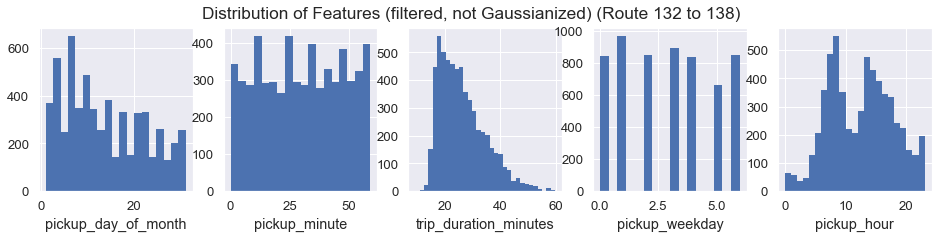

In [103]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16,3))
fig.suptitle('Distribution of Features (filtered, not Gaussianized) (Route {} to {})'.format(pickup_id, dropoff_id))
ax1.hist(df_one_route_filtered['pickup_day_of_month'], bins='scott', linewidth=0)
ax1.set_xlabel('pickup_day_of_month')

ax2.hist(df_one_route_filtered['pickup_minute'], bins='scott', linewidth=0)
ax2.set_xlabel('pickup_minute')

ax3.hist(df_one_route_filtered['trip_duration_minutes'], bins='scott', linewidth=0)
ax3.set_xlabel('trip_duration_minutes')

ax4.hist(df_one_route_filtered['pickup_weekday'], bins='scott', linewidth=0)
ax4.set_xlabel('pickup_weekday')

ax5.hist(df_one_route_filtered['pickup_hour'], bins='scott', linewidth=0)
ax5.set_xlabel('pickup_hour')
plt.show()

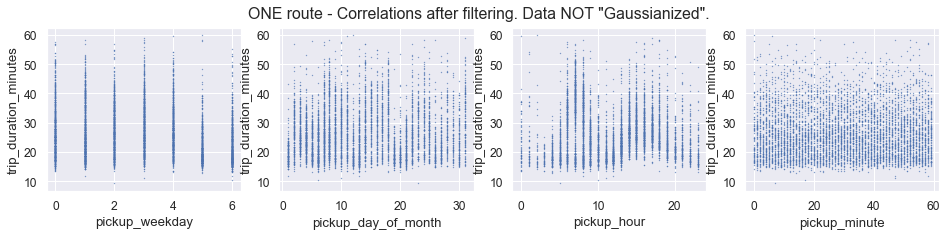

In [50]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))
fig.suptitle('ONE route - Correlations after filtering. Data NOT "Gaussianized".')

ax1.scatter(df_one_route_filtered['pickup_weekday'], df_one_route_filtered['trip_duration_minutes'], s=0.1)
ax1.set_xlabel('pickup_weekday')
ax1.set_ylabel('trip_duration_minutes')

ax2.scatter(df_one_route_filtered['pickup_day_of_month'], df_one_route_filtered['trip_duration_minutes'], s=0.1)
ax2.set_xlabel('pickup_day_of_month')
ax2.set_ylabel('trip_duration_minutes')

ax3.scatter(df_one_route_filtered['pickup_hour'], df_one_route_filtered['trip_duration_minutes'], s=0.1)
ax3.set_xlabel('pickup_hour')
ax3.set_ylabel('trip_duration_minutes')

ax4.scatter(df_one_route_filtered['pickup_minute'], df_one_route_filtered['trip_duration_minutes'], s=0.1)
ax4.set_xlabel('pickup_minute')
ax4.set_ylabel('trip_duration_minutes')

plt.show()

In [51]:
print('trip_duration_minutes: µ {:.2f} ± σ {:.2f} minutes'.format(df_one_route_filtered['trip_duration_minutes'].std(),
                                                                  df_one_route_filtered['trip_duration_minutes'].mean()))

trip_duration_minutes: µ 8.33 ± σ 26.27 minutes


Observations:
- There is **no** linear relationship in the data.
- The standard deviation / variablity within the data is much larger than the mean &rarr; No sensible prediction possible.

**"Gaussianize" Data:**

i.e., try to transform the target variable / features such that they are more similar to Gaussian shape &rarr; This would allow us to compute the Pearson correlation and correlation significance tests.

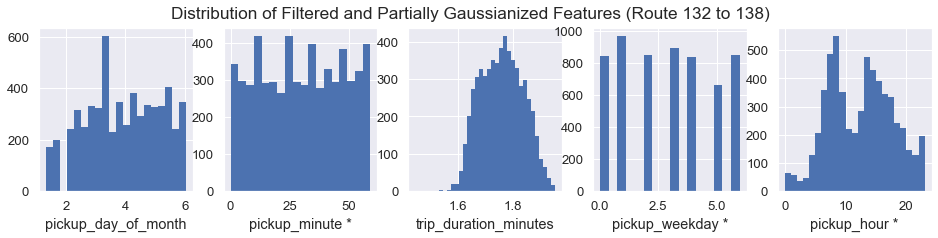

In [104]:
# Transformed distributions - Force to be as Gaussian as possible
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16,3))
fig.suptitle('Distribution of Filtered and Partially Gaussianized Features (Route {} to {})'.format(pickup_id, dropoff_id))

ax1.hist( stats.yeojohnson(np.cbrt(df_one_route_filtered['pickup_day_of_month']))[0], bins='scott', linewidth=0)
ax1.set_xlabel('pickup_day_of_month')

#ax2.hist( stats.yeojohnson((df_one_route_filtered['pickup_minute']))[0], bins='scott', linewidth=0)
ax2.hist( df_one_route_filtered['pickup_minute'], bins='scott', linewidth=0)
ax2.set_xlabel('pickup_minute *')

ax3.hist( stats.boxcox(df_one_route_filtered['trip_duration_minutes'], -0.42) , bins='scott', linewidth=0 )
ax3.set_xlabel('trip_duration_minutes')

ax4.hist( df_one_route_filtered['pickup_weekday'], bins='scott', linewidth=0)
ax4.set_xlabel('pickup_weekday *')

#ax5.hist( stats.yeojohnson(df_one_route_filtered['pickup_hour'])[0], bins='scott', linewidth=0)
ax5.hist( df_one_route_filtered['pickup_hour'], bins='scott', linewidth=0)
ax5.set_xlabel('pickup_hour *')
plt.show()

A  ``*``  symbol indicates that Gaussianization was not possible with simple transformations.

In [96]:
x0 = stats.boxcox(df_one_route_filtered['trip_duration_minutes'], -0.42)
x1 = stats.yeojohnson(np.cbrt(df_one_route_filtered['pickup_day_of_month']))[0]
x2 = (df_one_route_filtered['pickup_weekday']).values
x3 = df_one_route_filtered['pickup_hour']#stats.yeojohnson(df_one_route_filtered['pickup_hour'])[0]
x4 = (df_one_route_filtered['pickup_minute']).values#stats.yeojohnson(df_one_route_filtered['pickup_minute'])[0]

X = np.column_stack((x0, x1, x2, x3, x4))

In [97]:
df = pd.DataFrame(X, columns=df_one_route_filtered.columns)

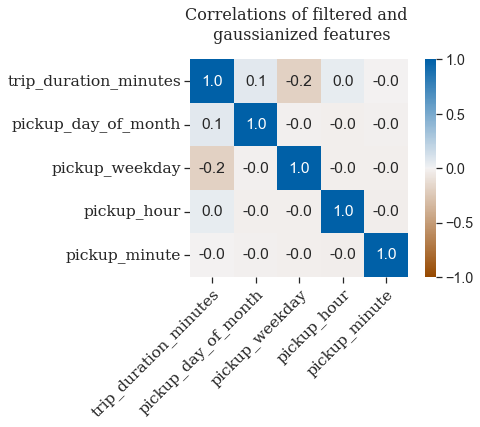

In [100]:
sns_font = {'font':'serif'} # Font face

corr       = df.corr()
corr.index = df.columns
# Color blindness safe plot
sns.set(font_scale=1.3)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 250, s=100, l=40, as_cmap=True),
    square=True,
    annot=True,
    fmt=".1f"
)

plt.setp(ax.get_yticklabels(), **sns_font)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", **sns_font)
ax.tick_params(left=True, bottom=True)
#plt.title("Correlations of Filtered and Gaussianized Features (Route {} to {})".format(pickup_id, dropoff_id), pad=20, fontsize=16)
plt.title("Correlations of filtered and \n gaussianized features", fontsize=16, pad=20, **sns_font)
plt.savefig('../doc/fig/correlations_gaussianized_columns_route_132_138.pdf', bbox_inches='tight')
plt.show()

In [73]:
df.corr()

,trip_duration_minutes,pickup_day_of_month,pickup_weekday,pickup_hour,pickup_minute
trip_duration_minutes,1.000000,0.063252,-0.191310,0.042527,-0.005347
pickup_day_of_month,0.063252,1.000000,-0.012561,-0.019267,-0.010037
pickup_weekday,-0.191310,-0.012561,1.000000,-0.021352,-0.019771
pickup_hour,0.042527,-0.019267,-0.021352,1.000000,-0.023846
pickup_minute,-0.005347,-0.010037,-0.019771,-0.023846,1.000000


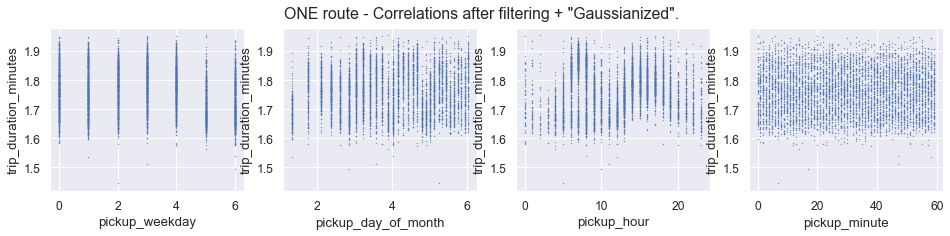

In [74]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))
fig.suptitle('ONE route - Correlations after filtering + "Gaussianized".')

ax1.scatter(x2, x0, s=0.1)
ax1.set_xlabel('pickup_weekday')
ax1.set_ylabel('trip_duration_minutes')

ax2.scatter(x1, x0, s=0.1)
ax2.set_xlabel('pickup_day_of_month')
ax2.set_ylabel('trip_duration_minutes')

ax3.scatter(x3, x0, s=0.1)
ax3.set_xlabel('pickup_hour')
ax3.set_ylabel('trip_duration_minutes')

ax4.scatter(x4, x0, s=0.1)
ax4.set_xlabel('pickup_minute')
ax4.set_ylabel('trip_duration_minutes')

plt.show()

In [75]:
print('trip_duration_minutes: µ {:.2f} ± σ {:.2f} minutes'.format(x0.std(),
                                                                  x0.mean()))

trip_duration_minutes: µ 0.08 ± σ 1.76 minutes


Conclusion: **No linear pattern** in the data. Not useful for linear regression.

---

**Tests for correlation:**

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Using_the_exact_distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

_Two-sided test for correlation based on the exact distribution of Pearson's r:_

* H0: **No** correlation between ``trip_duration_minutes`` and ``pickup_weekday``, i.e., they have no linear relationship.
* H1: ``trip_duration_minutes`` and ``pickup_weekday`` have significant correlation, thus, are related in some way.

In [92]:
pearson_coef, p_value = stats.pearsonr(x0, x2)
print('Peason correlation between "{}" and "{}":  r = {:.4f} with a p-value of {:.4f}'.format(df.columns[0],
                                                                                              df.columns[2],
                                                                                              pearson_coef,
                                                                                              p_value))

Peason correlation between "trip_duration_minutes" and "pickup_weekday":  r = -0.1916 with a p-value of 0.0000


Observations:
* r $\approx 0$ indicates that there is no correlation between the trip duration in minutes and the day of the week a passenger enters a taxi.
* From the highly significant p-value of about $0$ from the two-sided test for correlation we conclude that there acutually is no correlation between the two features.
  * The r value obtained it _too unlikely_ to having occured by chance!

<p>&nbsp;</p>
Furhter tests for correlation between features that we initially intended to use as predictors in our linear regression model:

In [93]:
pearson_coef, p_value = stats.pearsonr(x0, x1)
print('Peason correlation between "{}" and "{}":  r = {:.4f} with a p-value of {:.4f}'.format(df.columns[0],
                                                                                              df.columns[1],
                                                                                              pearson_coef,
                                                                                              p_value))

Peason correlation between "trip_duration_minutes" and "pickup_day_of_month":  r = 0.0630 with a p-value of 0.0000


In [94]:
pearson_coef, p_value = stats.pearsonr(x0, x3)
print('Peason correlation between "{}" and "{}":  r = {:.4f} with a p-value of {:.4f}'.format(df.columns[0],
                                                                                              df.columns[3],
                                                                                              pearson_coef,
                                                                                              p_value))

Peason correlation between "trip_duration_minutes" and "pickup_hour":  r = 0.0426 with a p-value of 0.0011


In [99]:
pearson_coef, p_value = stats.pearsonr(x0, x4)
print('Peason correlation between "{}" and "{}":  r = {:.4f} with a p-value of {:.4f}'.format(df.columns[0],
                                                                                              df.columns[4],
                                                                                              pearson_coef,
                                                                                              p_value))

Peason correlation between "trip_duration_minutes" and "pickup_minute":  r = -0.0053 with a p-value of 0.6853


The p-value is above the frequently used significance level of $\alpha=0.05$. Thus, the low correlation $r\approx0$ is not significant and might be due to chance. However, by looking at the plot of ``trip_duration_minutes`` vs. ``pickup_minute``, there is no structure visible in the data which rather favours that there actually is no relationship.

---

**Linear Regression Test:**

In [84]:
df

,trip_duration_minutes,pickup_day_of_month,pickup_weekday,pickup_hour,pickup_minute
0,1.681589,1.325313,1.0,1.0,27.0
1,1.744493,1.325313,1.0,4.0,42.0
2,1.665345,1.325313,1.0,4.0,51.0
3,1.640484,1.325313,1.0,5.0,29.0
4,1.672659,1.325313,1.0,5.0,58.0
...,...,...,...,...,...
5907,1.753700,6.024205,3.0,19.0,59.0
5908,1.843936,6.024205,3.0,19.0,7.0
5909,1.729261,6.024205,3.0,20.0,47.0
5910,1.929299,6.024205,3.0,20.0,31.0


In [85]:
# Split data into shuffled training and test set

target_clm = 'trip_duration_minutes' # Determine the target variable.
X = df.loc[:, df.columns != target_clm]
y = df.loc[:, df.columns == target_clm]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [96]:
# Fit linear regression model: Raw features WITHOUT preprocessing
weights, y_pred = sklearn_regression_bf(X_test, X_train, y_train, deg=3)

MSE:  0.004588303099852903
r^2:  0.2126716947956231


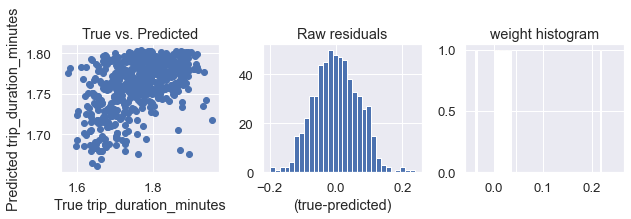

In [97]:
# Evaluate performance
plot_regression_results(y_test, y_pred, weights, target_clm)

Better result than plain linear regression but still very bad.

---

# Figures for Paper

In [19]:
from tueplots import bundles

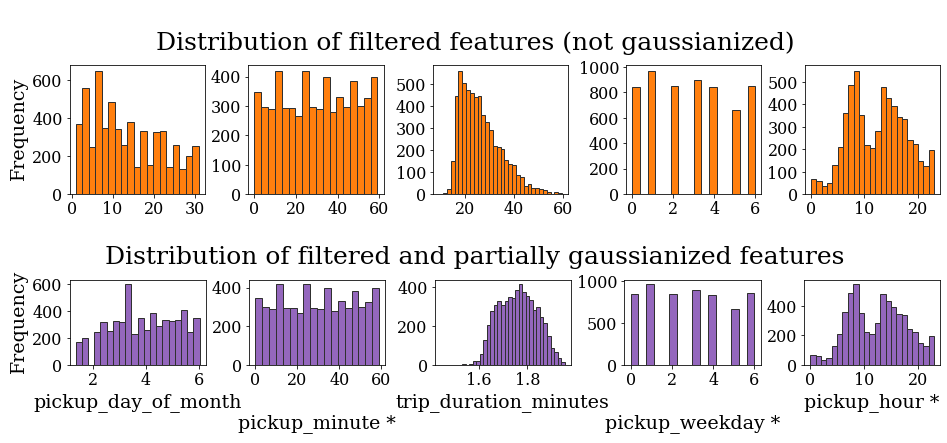

In [67]:
#with plt.rc_context(bundles.neurips2021(usetex=False)):

fsize_title = 25    # Subtitle font size
fsize_label = 19    # Label font size
fsize_ticks = 16    # Tick font size
label_vert_pad = 25 # Vertical padding for x-axis labels
font = {'fontname':'serif'}

fig = plt.figure(constrained_layout=True, figsize=(13, 6))

#(subfig1, subfig2) = fig.subfigures(2, 1, wspace=0.07, hspace=0.07) # create 2x1 subfigures
(subfig1, subfig2) = fig.subfigures(2, 1, wspace=0.07, hspace=0.1)
axs1 = subfig1.subplots(1, 5)                          # create 1x5 subplots on subfig1
axs2 = subfig2.subplots(1, 5)                          # create 1x5 subplots on subfig2

# Plot first row: UNtransformed features
#subfig1.suptitle('Distribution of filtered features (not gaussianized) - route {} to {}'.format(pickup_id, dropoff_id))
subfig1.suptitle('Distribution of filtered features (not gaussianized)', fontsize=fsize_title, **font)
axs1[0].hist(df_one_route_filtered['pickup_day_of_month'], bins='scott', color='tab:orange', edgecolor='#303030')
axs1[0].set_ylabel('Frequency', fontsize=fsize_label, **font)
#axs1[0].set_xlabel('pickup_day_of_month')

axs1[1].hist(df_one_route_filtered['pickup_minute'], bins='scott', color='tab:orange', edgecolor='#303030')
#axs1[1].set_xlabel('pickup_minute')

axs1[2].hist(df_one_route_filtered['trip_duration_minutes'], bins='scott', color='tab:orange', edgecolor='#303030')
#axs1[2].set_xlabel('trip_duration_minutes')

axs1[3].hist(df_one_route_filtered['pickup_weekday'], bins='scott', color='tab:orange', edgecolor='#303030')
#axs1[3].set_xlabel('pickup_weekday')

axs1[4].hist(df_one_route_filtered['pickup_hour'], bins='scott', color='tab:orange', edgecolor='#303030')
#axs1[4].set_xlabel('pickup_hour')

# Plot second row: Partly Gaussianized features
#subfig2.suptitle('Distribution of filtered and partially gaussianized features - route {} to {}'.format(pickup_id, dropoff_id))
subfig2.suptitle('Distribution of filtered and partially gaussianized features', fontsize=fsize_title, **font)
axs2[0].hist( stats.yeojohnson(np.cbrt(df_one_route_filtered['pickup_day_of_month']))[0], color='tab:purple', bins='scott', edgecolor='#303030')
axs2[0].set_ylabel('Frequency', fontsize=fsize_label, **font)
axs2[0].set_xlabel('pickup_day_of_month', fontsize=fsize_label, **font)

axs2[1].hist( df_one_route_filtered['pickup_minute'], bins='scott', color='tab:purple', edgecolor='#303030')
axs2[1].set_xlabel('pickup_minute *', fontsize=fsize_label, labelpad=label_vert_pad, **font)

axs2[2].hist( stats.boxcox(df_one_route_filtered['trip_duration_minutes'], -0.42) , bins='scott', color='tab:purple', edgecolor='#303030')
axs2[2].set_xlabel('trip_duration_minutes', fontsize=fsize_label, **font)

axs2[3].hist( df_one_route_filtered['pickup_weekday'], bins='scott', color='tab:purple', edgecolor='#303030')
axs2[3].set_xlabel('pickup_weekday *', fontsize=fsize_label, labelpad=label_vert_pad, **font)

axs2[4].hist( df_one_route_filtered['pickup_hour'], bins='scott', color='tab:purple', edgecolor='#303030')
axs2[4].set_xlabel('pickup_hour *', fontsize=fsize_label, **font)

fig.suptitle(' ', fontsize='xx-large')

# Increase tick font size
plt.setp(axs1[0].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs1[1].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs1[2].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs1[3].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs1[4].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[0].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[1].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[2].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[3].get_xticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[4].get_xticklabels(), fontsize=fsize_ticks, **font)

plt.setp(axs1[0].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs1[1].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs1[2].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs1[3].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs1[4].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[0].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[1].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[2].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[3].get_yticklabels(), fontsize=fsize_ticks, **font)
plt.setp(axs2[4].get_yticklabels(), fontsize=fsize_ticks, **font)

plt.savefig('../doc/fig/feature_distributions.pdf', bbox_inches='tight')
plt.show()

<center>Route: Location ID 132 to ID 138.</center>

---

**QuantileTransformer to make distribution Gaussian:**

In [106]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
X = np.sort(df_all_routes['trip_distance'].normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)
qt = QuantileTransformer(n_quantiles=10, random_state=0)
qt.fit_transform(X)

In [226]:
df_all_routes.head(3)

,PULocationID,DOLocationID,trip_distance,total_amount,trip_duration_minutes,pickup_weekday,pickup_hour
722,1,5,52.0,20.80,14.066667,4,0
1747,2,1,45.0,14.30,12.250000,4,0
2226,1,4,25.0,24.35,13.966667,4,0


In [118]:
df_all_routes.shape

(494105, 12)

In [159]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
X_trans = quantile_transformer.fit_transform(df_all_routes)
quantile_transformer.quantiles_

array([[1.00000000e+00, 0.00000000e+00, 1.00000000e-02, ...,
        5.01666667e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.00000000e+00, 1.40000000e-01, ...,
        5.03333333e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 3.00000000e+00, 3.00000000e-01, ...,
        5.05000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.60000000e+02, 2.63000000e+02, 3.13320721e+01, ...,
        8.59534535e+01, 6.00000000e+00, 2.30000000e+01],
       [2.60000000e+02, 2.63000000e+02, 4.20000000e+01, ...,
        9.21351351e+01, 6.00000000e+00, 2.30000000e+01],
       [2.63000000e+02, 2.63000000e+02, 5.40000000e+01, ...,
        1.04983333e+02, 6.00000000e+00, 2.30000000e+01]])

In [160]:
X_trans.shape

(494105, 7)

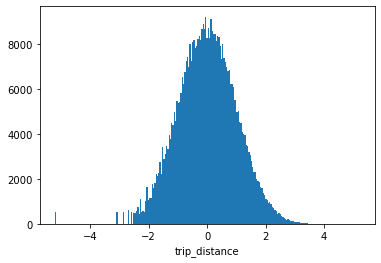

In [180]:
plt.hist(X_trans[:,4], bins='scott')
plt.xlabel('trip_distance')
plt.show()

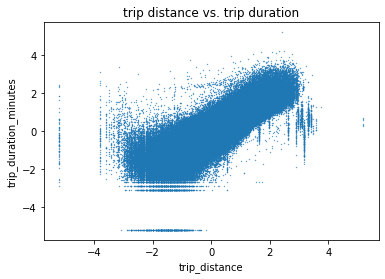

In [178]:
plt.scatter(X_trans[:,2], X_trans[:,4], s=0.1)
plt.title('trip distance vs. trip duration')
plt.xlabel('trip_distance')
plt.ylabel('trip_duration_minutes')
plt.plot();

[]

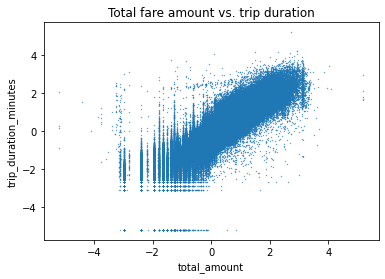

In [181]:
plt.scatter(X_trans[:,3], X_trans[:,4], s=0.1)
plt.title('Total fare amount vs. trip duration')
plt.xlabel('total_amount')
plt.ylabel('trip_duration_minutes')
plt.plot()

---

In [165]:
df = pd.DataFrame(X_trans, columns=df_all_routes.columns)

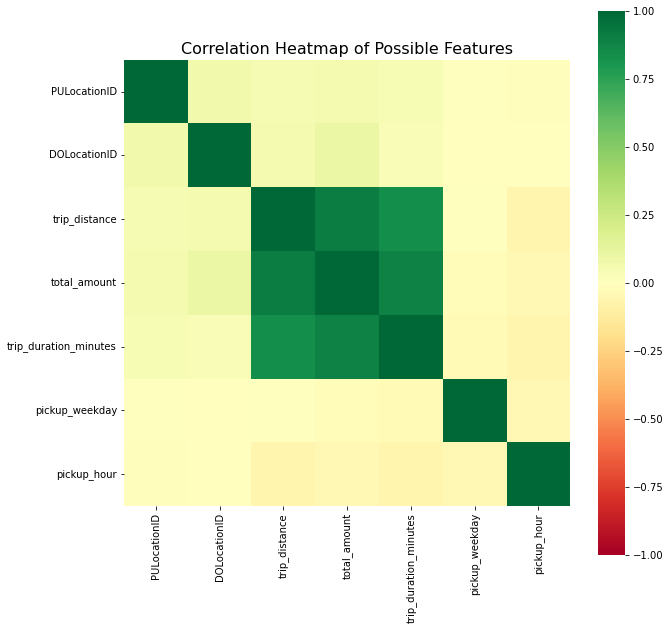

In [170]:
plt.figure(figsize=(10,10))
corr       = df.corr()
corr.index = df_all_routes.columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap of Possible Features", fontsize=16)
plt.show()